# Task 2: Counting buildings without detecting them

Pratichhya Sharma

The main idea is to count objects indirectly by estimating a density map. The scripts and the concept for this task is inspired from https://github.com/NeuroSYS-pl/objects_counting_dmap.git. Though two model are suggested but here we used classical Unet with modified final layer that would provide us with the density map. Both the models are included in model.py. 

The common way of count objects using DL is to first detect them using convolutional neural networks, and then count all found instances. It is effective but requires bounding box annotations, which are hard to obtain. To overcome this issue, alternative approaches leverage point-like annotations of objects positions, which are much cheaper to collect. This method has been explored in this task.

Dataset used for task 1 was taken for completion of this task. Despite multiple classes, these dwellings were convered to point feature that represented 1 point for 1 dwellings as required by the paper for performing this method.

In [1]:
# import packages
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import matplotlib.patches as mpatches

In [2]:
#function to plot
def visualize_data(image,label):
    f, axarr = plt.subplots(1,2)
    image = image[:, :, 0:3]
    _ = image[:, :, 0].copy()
    image[:, :, 0] = image[:, :, 2]
    image[:, :, 2] = _
    image = image.astype(np.float64)
    for i in range(image.shape[2]):
        p2, p98 = np.percentile(image[:, :, i], (2, 98))
        image[:, :, i] = exposure.rescale_intensity(image[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(image)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(label.ravel())
    im = axarr[1].imshow(label[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    label = ["No Dwellings","Blue Dwellings", "Bright Dwellings","Iron Roof Dwellings","Dark Dwellings","Dismantled Dwellings","Green Dwellings","Red Dwellings"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), label)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

In [3]:
Xmain = np.load('/pratichhya_sharma/CD/data_loader/used_data/Xdata_128CD.npy')
Ymain = np.load('/pratichhya_sharma/CD/data_loader/used_data/Ydata_128CD.npy')# load
Xmain.shape, Ymain.shape

((320, 3, 128, 128), (320, 1, 128, 128))

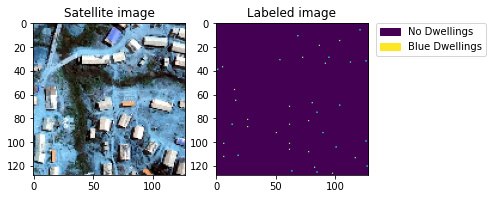

In [4]:
#example of the dataset
visualize_data(np.swapaxes(Xmain[220,:,:,:],0,2),np.swapaxes(Ymain[220,:,:,:],0,2))

As seen above the satellite image is a patch from the entire dataset whereas the labeled image represents the points for each dwellings. Once the model is trained then the output is a density map for each of these patches.

The main idea is to count objects indirectly by estimating a density map. The first step is to prepare training samples, so that for every image there is a corresponding density map.A density map is obtained by applying a convolution with a Gaussian kernel (and normalized so that integrating it gives the number of objects). Thus, the goal is to train a fully convolutional network to map an image to a density map, which can be later integrated to get the number of objects.

Few examples of these density maps are:

<img src=./densitymap.png width="1000" height="500">

Hence, the result obtained at the end of this method is count of dwelling/density points that represents the dwellings i.e
**"Total number of buildings observed is [ 1. 18.  3. 14. 15. 22.  7. 17.]/[ 0. 51. 11. 50. 40. 69. 18. 46.] during epoch 250 Evaluation phase"**. Sample of this data is saved in count_record.txt